In [1]:
import numpy as np
import scipy
from scipy.interpolate import interp1d

In [2]:
#generate MV , CV signal

In [3]:
MV = np.ones(1000)*100

In [4]:
MV[20:50] = 80
MV[150:200] = 140
MV[300:500] =  140

In [5]:
def fopdt(u,k,tau,dt):
    y = 0
    ys = []
    ts = range(len(u))
    uf= interp1d(ts,u)
    for t in ts:
    
        if (t-dt) < 0:
            dydt=0
        else:
            dydt =  (k*uf(t-dt) - y)/tau # look at the brackets  , instead of square brackets. 
            
        y += dydt
        ys.append(y)
    y_arr = np.array(ys)
    return y_arr

In [6]:
dev_MV = MV - MV[0]

In [7]:
y = fopdt(dev_MV,4,20,5)

In [8]:
%timeit fopdt(dev_MV,4,20,5)

46 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
import matplotlib.pyplot as plt

In [10]:
plt.plot(y)

In [11]:
%matplotlib inline

In [12]:
y = y + 200

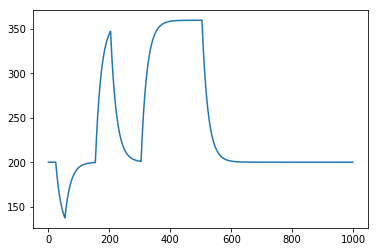

In [13]:
plt.plot(y)

In [14]:
noise = np.random.rand(len(y))*20

In [15]:
y = y +noise

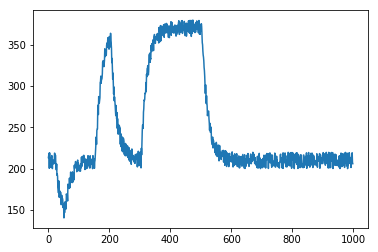

In [16]:
plt.plot(y)

In [17]:
np.c_[MV,y]

array([[ 100.        ,  213.50199207],
       [ 100.        ,  215.86825445],
       [ 100.        ,  218.85977807],
       ..., 
       [ 100.        ,  219.35630688],
       [ 100.        ,  207.66081713],
       [ 100.        ,  206.15288296]])

In [29]:
#introduce slow drifting in y


In [30]:
np.savetxt("simulated_noise_only.csv",np.c_[MV,y],delimiter=",",fmt='%1.3f')

In [31]:
disturbance = np.zeros(1000)
disturbance[700:1000] = 1

In [32]:
y_dist = fopdt(disturbance,50,20,0)

In [33]:
y_dist = y_dist + y

In [34]:
np.savetxt("simulated_input_disturbance.csv",np.c_[MV,y_dist],delimiter=",",fmt='%1.3f')

In [18]:
# for a ramp process , the ramp gain itself can follow a first order process. 
# for example , when you inrease a flow set point , the flow PV can follow a first order proess
# so a term dynamic gain is used (dyn_k) .  The "k" is the steady state gain per min. 
def ramp(u,k,tau,dt):
    y = 0
    dyn_k = 0 
    ys = []
    ts = range(len(u))
    uf= interp1d(ts,u)
    for t in ts:
    
        if (t-dt) < 0:
            roc_dydt=0
        else:
            dkdt =  (k*uf(t-dt) - dyn_k )/tau
            dyn_k += dkdt
            
        y += dyn_k
        ys.append(y)
    y_arr = np.array(ys)
    return y_arr

In [19]:
y_ramp =  ramp(dev_MV,0.1,10,0)

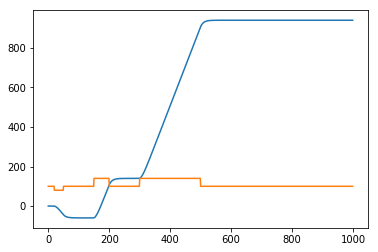

In [20]:
plt.plot(y_ramp)
plt.plot(MV)

In [43]:
y_ramp_dist = ramp(disturbance,-0.5,10,1)

In [44]:
y_ramp = y_ramp+ y_ramp_dist + noise

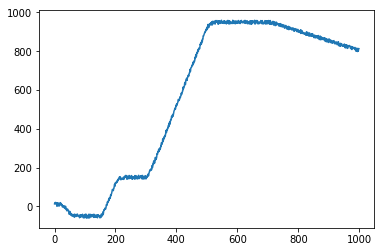

In [45]:
plt.plot(y_ramp)

In [46]:
np.savetxt("ramp.csv",np.c_[y_ramp],delimiter=",",fmt='%1.3f')

In [57]:
# in a first order system , the rate of change is proportional to driving force. 
# in a second order system , there are two driving forces 
# first  driving force is between dydt and d2ydt2
# second driving force is between dydt and y 
def secondorder(u,k,beta,tau1,tau2,dt):
    y  = 0
    dy2dt2 = 0
    dydt = 0
    ys = []
    ts = range(len(u))
    u_int = interp1d(ts,u)
    for t in ts :
        if (t-dt ) < 0:
            dy2dt2 = 0
            dydt = 0
        else:
            dy2dt2 = (k*u_int(t-dt) - y - tau1*dydt) /(tau2*tau2)  # driving force for d2ydt2
            
            dydt = dydt + dy2dt2
            
        y += dydt
        ys.append(y)
    y_arr = np.array(ys)
    return y_arr
     

In [58]:
y_sec = secondorder(dev_MV,3,0,3,5,0)

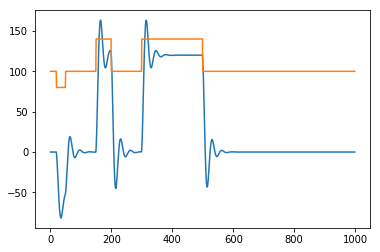

In [60]:
plt.plot(y_sec)
plt.plot(MV)

In [61]:
y_sec = secondorder(dev_MV,3,0,20,5,0)

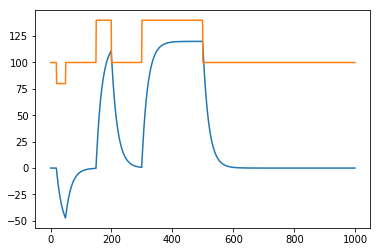

In [62]:
plt.plot(y_sec)
plt.plot(MV)

In [163]:
# second order systems due to beta 
#note that second order systems arise , either due two first order system in series or parallel
# we will consider only series case.  
# difference of two first order systems , with two different gains and time constant
#http://my.chemeng.queensu.ca/courses/CHEE319/documents/CHEE319_notes_2012_lecture4.pdf
#http://www-unix.ecs.umass.edu/~rlaurenc/Courses/ChE446/Second/1Inverse/Inverse1.html

def secondorderbeta(u,k,beta,tau1,tau2,dt):
    y  = 0
    y1=0
    y2=0
    dydt1 = 0
    dydt2 = 0
    ys = []
    ts = range(len(u))
    u_int = interp1d(ts,u)
    for t in ts :
        if (t-dt ) < 0:
            
            dydt1 = 0
            dydt2 = 0
        else:
            #dydt1 = (k*u_int(t-dt) - y)/tau1 #driving force 1 , the self regulating factor is y just like a normal first order process
            dydt2 = -(5*u_int(t-dt) - y2) /tau2 # there is another driving force that is in opposite direction, for example , this is the 
            y2 +=  dydt2
            dydt1 = (10*u_int(t-dt) - y1)/tau1
            y1 +=  dydt1
            y += (dydt1+dydt2)
            # reboiler to quality dynamics , the quality should initially increase in direction and settle                
            
            
        
        ys.append(y)
    y_arr = np.array(ys)
    return y_arr


In [30]:
MV1 = np.zeros(1000)
MV1[50:200] = 1

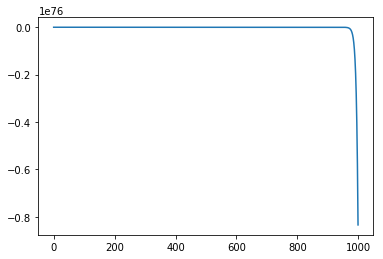

In [164]:
y_sec_beta = secondorderbeta(MV1,2,-5,20,5,0)
plt.plot(y_sec_beta)

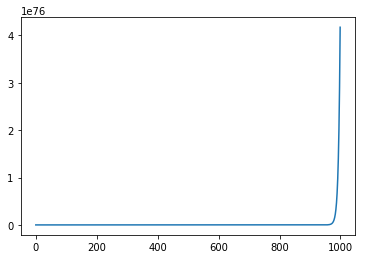

In [80]:
y_sec = secondorder(MV1,5,0,8,5,0)

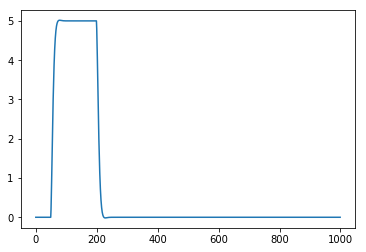

In [81]:
plt.plot(y_sec)

In [82]:
# tested for critical damping , under damping and over damping. seems ok 

In [26]:
# inverese response is caused by two parallel processes , having opposite gain , and the first process has much shorter 
#settling time than the second process. 
def secondorder2(u,k1,k2,tau1,tau2,dt):
    y=0
    y1  = 0
    y2 = 0
    dy1dt =0
    dy2dt = 0
    dydt = 0
    ys = []
    ts = range(len(u))
    u_int = interp1d(ts,u)
    for t in ts :
        if (t-dt ) < 0:
            dy1dt = 0
            dy2dt =0
            dydt = 0
        else:
            dy1dt = (k1*u_int(t-dt) - y1) /tau1  # driving force for dy1dt
            y1 += dy1dt
            dy2dt = (k2*u_int(t-dt) - y2) /tau2
            y2 += dy2dt
        y += (dy1dt+dy2dt)
        ys.append(y)
    y_arr = np.array(ys)
    return y_arr

In [35]:
y_sec2 = secondorder2(MV1,-5,10,20,5,0)

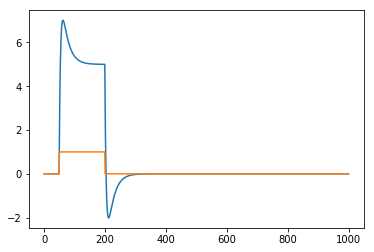

In [36]:
plt.plot(y_sec2)
plt.plot(MV1)

In [37]:
y_sec2 = secondorder2(MV1,-5,5,20,5,0)

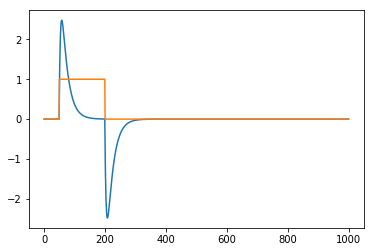

In [38]:
plt.plot(y_sec2)
plt.plot(MV1)

In [70]:
from models import models

In [71]:
mod = models.FirstOrder(2,10,0)


In [72]:
mod.step()

TypeError: step() takes 0 positional arguments but 1 was given

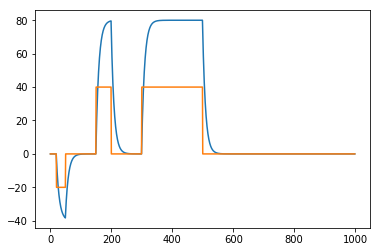

In [58]:
plt.plot(output)
plt.plot(dev_MV)

In [9]:
from models import models

In [10]:
mod = models.FirstOrder(k=5,tau=10,dt=0)

NameError: name 'u' is not defined